In [26]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score
X_train = pd.read_csv("data/x_train.txt",header=None,sep=" ")
y_train = pd.read_csv("data/y_train.txt",header=None,sep=" ")

def eval_proba(probas,y,n_features, num_target = 1000):
    sorted_probas = np.sort(probas)[::-1]  
    threshold = sorted_probas[num_target - 1]

    y_pred = (probas >= threshold).astype(int)
    gain = 10*precision_score(y, y_pred)*num_target
    return gain - 200*n_features, precision_score(y, y_pred)

Testy czy są jakieś zmienne widoczne do odsiania na start i nie bardzo. Istotność jest wmiare równomierna.

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import f_classif
import matplotlib.pyplot as plt
import seaborn as sns
f_values, p_values = f_classif(X_train, y_train)


anova_df = pd.DataFrame({
    'Feature': range(len(p_values)),  
    'p_values': p_values
})
anova_df.sort_values('p_values',ascending=False)

c:\Users\karim\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Feature,p_values
111,111,9.997676e-01
296,296,9.991506e-01
448,448,9.977965e-01
53,53,9.975327e-01
466,466,9.944021e-01
...,...,...
4,4,7.587568e-117
7,7,1.062914e-119
6,6,1.980223e-134
3,3,2.693812e-135


RFE + XGBOOST(chyba bez sensu trzeba raczej budować niz redukować)

In [3]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score


def evaluate_rfe_with_custom_score(X, y, step=1, min_features=1, max_features=15, cv=5):
    y= np.array(y)
    num_target=1000
    n_splits = 5
    for n_features in range(min_features, max_features + 1, step):
        print(f"Testing on {n_features} features")
        model = XGBClassifier()
        selector = RFE(estimator=model, n_features_to_select=n_features, step=0.25, verbose=0)
        selector.fit(X, y)
        X_selected = selector.transform(X)
        X_selected = np.array(X_selected)
        cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        probas = np.zeros(X.shape[0])  

        for train_idx, test_idx in cv.split(X_selected, y):
            X_train, X_val = X_selected[train_idx,], X_selected[test_idx,]
            y_train, y_val = y[train_idx], y[test_idx]
    
            model = XGBClassifier(
            )
            
            model.fit(
                X_train, y_train,
                verbose=False
            )
            
            probas[test_idx] = model.predict_proba(X_val)[:,1]

        sorted_probas = np.sort(probas)[::-1]  
        threshold = sorted_probas[num_target - 1]

        y_pred = (probas >= threshold).astype(int)
        gain = 10*precision_score(y, y_pred)*num_target
        print (gain - 200*n_features)

results = evaluate_rfe_with_custom_score(X_train, y_train)



Testing on 1 features
7018.344965104686
Testing on 2 features
6559.999999999999
Testing on 3 features
6379.999999999999
Testing on 4 features
6330.0
Testing on 5 features
6199.999999999999
Testing on 6 features
6010.0
Testing on 7 features
5780.0
Testing on 8 features
5460.0
Testing on 9 features
5460.0
Testing on 10 features
5330.0
Testing on 11 features
5100.0
Testing on 12 features
4900.0
Testing on 13 features
4660.0
Testing on 14 features
4429.999999999999
Testing on 15 features
4260.0


In [ ]:
import numpy as np
import pandas as pd
from collections import namedtuple
from itertools import product
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import mutual_info_classif, RFE
from sklearn.metrics import precision_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
import shap


def evaluate_all_combinations(
        X: pd.DataFrame,
        y,
        feature_counts=(5, 10, 15),
        n_splits: int = 5,
        num_target: int = 1_000,
        random_state: int = 42):

    def l1_logreg(X, y, k):
        model = LogisticRegression(penalty='l1', solver='liblinear', C=0.1)
        model.fit(X, y)
        ranking = np.argsort(np.abs(model.coef_[0]))[::-1]
        return ranking[:k]

    def rf_importance(X, y, k):
        rf = RandomForestClassifier(n_estimators=250, random_state=random_state)
        rf.fit(X, y)
        ranking = np.argsort(rf.feature_importances_)[::-1]
        return ranking[:k]

    def xgb_shap(X, y, k):
        xgb = XGBClassifier(use_label_encoder=False,
                            eval_metric='logloss',
                            random_state=random_state)
        xgb.fit(X, y)
        explainer = shap.TreeExplainer(xgb)
        shap_vals = explainer.shap_values(X.sample(n=min(1_000, len(X)),
                                                   random_state=random_state))
        shap_mean = np.abs(shap_vals).mean(axis=0)
        ranking = np.argsort(shap_mean)[::-1]
        return ranking[:k]

    def mutual_info(X, y, k):
        mi = mutual_info_classif(X, y, random_state=random_state)
        ranking = np.argsort(mi)[::-1]
        return ranking[:k]

    def rfe_logreg(X, y, k):
        rfe = RFE(LogisticRegression(), n_features_to_select=k)
        rfe.fit(X, y)
        return np.where(rfe.support_)[0]

    SELECTORS = {
        "L1-LogReg":        l1_logreg,
        "RF-imp":           rf_importance,
        "XGB-SHAP":         xgb_shap,
        "MutualInfo":       mutual_info,
        "RFE-LogReg":       rfe_logreg,
    }

    CLASSIFIERS = {
        "LogReg": LogisticRegression(max_iter=1_000, random_state=random_state),
        "RandomForest": RandomForestClassifier(
            n_estimators=500, random_state=random_state),
        "GaussianNB": GaussianNB(),
        "XGB": XGBClassifier(use_label_encoder=False,
                             eval_metric='logloss',
                             random_state=random_state),
    }

    Result = namedtuple("Result", "selector clf k n_feats precision score")
    results = []
    skf = StratifiedKFold(
        n_splits=n_splits, shuffle=True, random_state=random_state)
    y_np = np.asarray(y)

    def evaluate_single(X_sel, clf_name, clf):
        """CV + custom profit metric"""
        probas = np.zeros(len(y_np))
        for tr_idx, te_idx in skf.split(X_sel, y_np):
            clf.fit(X_sel.iloc[tr_idx], y_np[tr_idx])
            probas[te_idx] = clf.predict_proba(X_sel.iloc[te_idx])[:, 1]

        thresh = np.sort(probas)[::-1][num_target - 1]
        y_pred = (probas >= thresh).astype(int)
        prec = precision_score(y_np, y_pred)
        return prec

    for (sel_name, sel_fun), k, (clf_name, clf_template) in product(
            SELECTORS.items(), feature_counts, CLASSIFIERS.items()):
        idx = sel_fun(X, y, k)
        X_sub = X.iloc[:, idx]
        clf = clf_template.__class__(**clf_template.get_params())

        prec = evaluate_single(X_sub, clf_name, clf)
        score = prec * 10_000 - X_sub.shape[1] * 200
        results.append(Result(sel_name, clf_name, k,
                              X_sub.shape[1], prec, score))
        print(f"{sel_name:.10} + {clf_name:.12} k={k} | Prec={prec:.4f} | Score={score:.2f}")

    results.sort(key=lambda r: r.score, reverse=True)

    print("\nTOP 10 kombinacji:")
    for r in results[:10]:
        print(f"{r.selector:<10} + {r.clf:<12} k={r.k} | features={r.n_feats:.4f} | prec={r.precision:.4f} |  score{r.score:.2f}")

    return results


In [ ]:
results = evaluate_all_combinations(X_train, y_train, feature_counts=[i for i in range(1, 30, 2)])
# evaluate_all_combinations(X_train, y_train, feature_counts=[2])

L1-LogReg + LogReg k=1 | Prec=0.4990 | Score=4790.00
L1-LogReg + RandomForest k=1 | Prec=0.4746 | Score=4545.76
L1-LogReg + GaussianNB k=1 | Prec=0.4940 | Score=4740.00
L1-LogReg + XGB k=1 | Prec=0.4721 | Score=4520.56
L1-LogReg + LogReg k=3 | Prec=0.5440 | Score=4840.00
L1-LogReg + RandomForest k=3 | Prec=0.4711 | Score=4111.16
L1-LogReg + GaussianNB k=3 | Prec=0.5430 | Score=4830.00
L1-LogReg + XGB k=3 | Prec=0.4990 | Score=4390.00
L1-LogReg + LogReg k=5 | Prec=0.5420 | Score=4420.00
L1-LogReg + RandomForest k=5 | Prec=0.4945 | Score=3945.16
L1-LogReg + GaussianNB k=5 | Prec=0.5490 | Score=4490.00
L1-LogReg + XGB k=5 | Prec=0.5090 | Score=4090.00
L1-LogReg + LogReg k=7 | Prec=0.5320 | Score=3920.00
L1-LogReg + RandomForest k=7 | Prec=0.5040 | Score=3639.60
L1-LogReg + GaussianNB k=7 | Prec=0.5320 | Score=3920.00
L1-LogReg + XGB k=7 | Prec=0.5040 | Score=3640.00
L1-LogReg + LogReg k=9 | Prec=0.5430 | Score=3630.00
L1-LogReg + RandomForest k=9 | Prec=0.5183 | Score=3382.69
L1-LogReg + 

[Result(selector='RF-imp', clf='LogReg', k=1, n_feats=1, precision=0.729, score=7090.0),
 Result(selector='RF-imp', clf='GaussianNB', k=1, n_feats=1, precision=0.729, score=7090.0),
 Result(selector='XGB-SHAP', clf='LogReg', k=1, n_feats=1, precision=0.729, score=7090.0),
 Result(selector='XGB-SHAP', clf='GaussianNB', k=1, n_feats=1, precision=0.729, score=7090.0),
 Result(selector='MutualInfo', clf='LogReg', k=1, n_feats=1, precision=0.729, score=7090.0),
 Result(selector='MutualInfo', clf='GaussianNB', k=1, n_feats=1, precision=0.729, score=7090.0),
 Result(selector='RF-imp', clf='XGB', k=1, n_feats=1, precision=0.7218344965104686, score=7018.344965104686),
 Result(selector='XGB-SHAP', clf='XGB', k=1, n_feats=1, precision=0.7218344965104686, score=7018.344965104686),
 Result(selector='MutualInfo', clf='XGB', k=1, n_feats=1, precision=0.7218344965104686, score=7018.344965104686),
 Result(selector='XGB-SHAP', clf='RandomForest', k=3, n_feats=3, precision=0.739, score=6790.0),
 Result(s

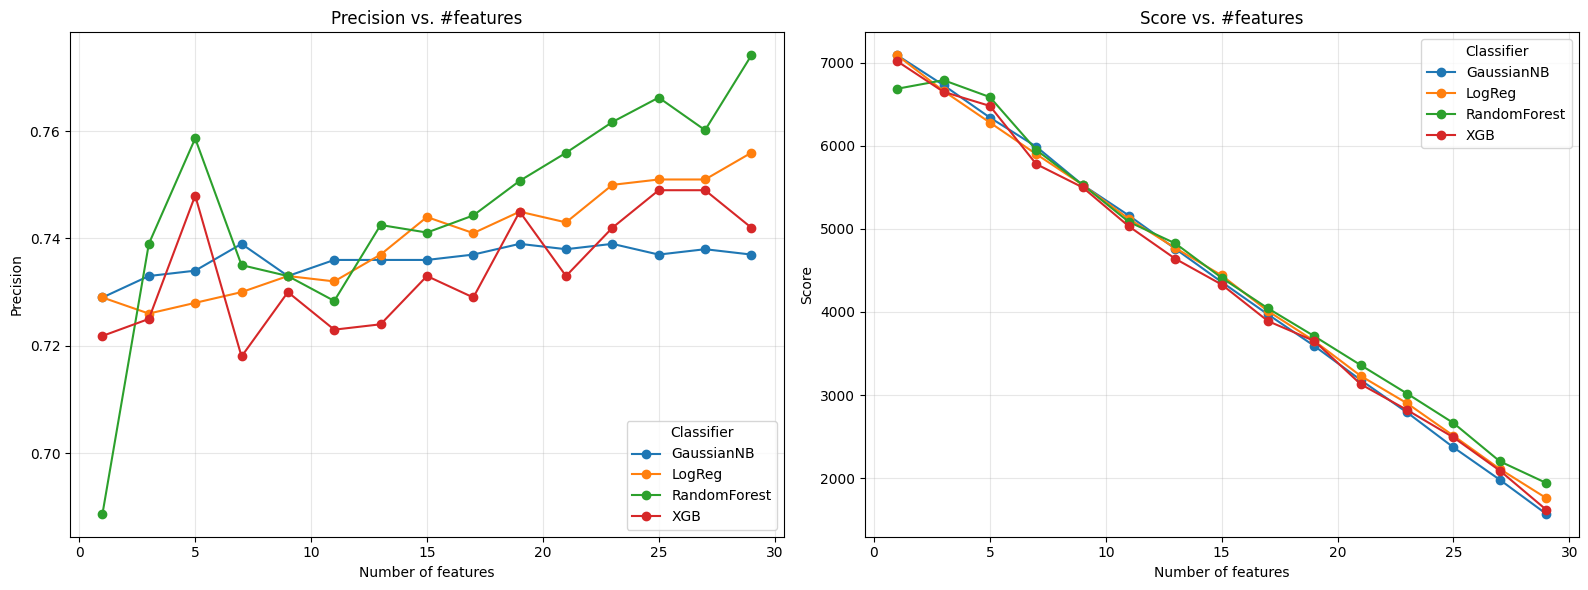

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame(results)  
metrics = ["precision", "score"]
fig, axes = plt.subplots(1, len(metrics), figsize=(14, 6), sharex=True)

for metric, ax in zip(metrics, axes):
    for (clf, selector), grp in df.groupby(["clf", "selector"]):
        best = grp.groupby("n_feats")[metric].max().sort_index()
        label = f"{clf} | {selector}"
        ax.plot(best.index, best.values, marker="o", label=label)
    ax.set_xlabel("Number of selected features")
    ax.set_ylabel(metric.capitalize())
    ax.set_title(f"{metric.capitalize()} vs #features")
    ax.grid(alpha=0.3)
    ax.legend(fontsize=8, title="Model | Selector")
plt.tight_layout()
plt.show()

Powinno wyjść tak samo a nie jest nie mam pojecia czemu

In [29]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_predict
import pandas as pd
from sklearn.feature_selection import RFE
import numpy as np
from sklearn.metrics import precision_score

X_train = pd.read_csv("data/x_train.txt",header=None,sep=" ")
y_train = pd.read_csv("data/y_train.txt",header=None,sep=" ")
num_target=1000
n_splits = 5
X_train, y_train = np.array(X_train), np.array(y_train).T[0]
for n_features in range(1, 15 + 1, 1):
    print(f"Testing on {n_features} features")
    model = XGBClassifier()
    selector = RFE(estimator=model, n_features_to_select=n_features, step=0.25, verbose=0)
    selector.fit(X_train, y_train)
    X_selected = selector.transform(X_train)
    model = XGBClassifier()

    probas = cross_val_predict(model, X_selected, y_train, cv=n_splits, method='predict_proba')[:,1]
    sorted_probas = np.sort(probas)
    threshold = sorted_probas[num_target - 1]

    y_pred = (probas >= threshold).astype(int)
    gain = 10*precision_score(y_train, y_pred)*num_target
    print (gain - 200*n_features)


Testing on 1 features
5267.032967032967
Testing on 2 features
5048.637840539865
Testing on 3 features
4898.6253436640845
Testing on 4 features


KeyboardInterrupt: 

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import make_scorer, precision_score
from sklearn.preprocessing import StandardScaler

X_train = pd.read_csv("data/x_train.txt",header=None,sep=" ")
y_train = pd.read_csv("data/y_train.txt",header=None,sep=" ")
num_target=1000
n_splits = 5
X_train, y_train = np.array(X_train), np.array(y_train).T[0]

X_train = StandardScaler().fit_transform(X_train)

n_features = X_train.shape[1]

max_features = 15
model = LogisticRegression(max_iter=1000)

selected = []
remaining = list(range(n_features))
best_score = 0
precision = make_scorer(precision_score, zero_division=0)

for _ in range(max_features):
    best_candidate_score = 0
    for i in remaining:
        current_features = selected + [i]
        probas = cross_val_predict(model, X_train[:,current_features], y_train, cv=n_splits, method='predict_proba')[:,1]
        score = eval_proba(probas, y_train,len(current_features))
        if score > best_candidate_score:
            best_candidate = i
            best_candidate_score = score
    
    
    selected.append(best_candidate)
    remaining.remove(best_candidate)
    print(best_candidate_score,selected)



7190.0 [3]
7060.0 [3, 298]
6920.0 [3, 298, 343]
6750.0 [3, 298, 343, 344]
6580.0 [3, 298, 343, 344, 495]
6430.0 [3, 298, 343, 344, 495, 135]
6250.0 [3, 298, 343, 344, 495, 135, 45]
6050.0 [3, 298, 343, 344, 495, 135, 45, 149]
5860.0 [3, 298, 343, 344, 495, 135, 45, 149, 190]
5660.0 [3, 298, 343, 344, 495, 135, 45, 149, 190, 104]
5470.0 [3, 298, 343, 344, 495, 135, 45, 149, 190, 104, 70]
5290.0 [3, 298, 343, 344, 495, 135, 45, 149, 190, 104, 70, 276]
5100.0 [3, 298, 343, 344, 495, 135, 45, 149, 190, 104, 70, 276, 261]
4910.0 [3, 298, 343, 344, 495, 135, 45, 149, 190, 104, 70, 276, 261, 277]
4710.0 [3, 298, 343, 344, 495, 135, 45, 149, 190, 104, 70, 276, 261, 277, 43]

Wybrane cechy (indeksy): [3, 298, 343, 344, 495, 135, 45, 149, 190, 104, 70, 276, 261, 277, 43]


In [27]:
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import RFE

X_train = pd.read_csv("data/x_train.txt",header=None,sep=" ")
y_train = pd.read_csv("data/y_train.txt",header=None,sep=" ")
num_target=1000
n_splits = 5
X_train, y_train = np.array(X_train), np.array(y_train).T[0]
n_features = X_train.shape[1]
max_features = 15
selected = []
best_score = 0
selector = SelectKBest(score_func=f_classif, k=max_features)
X_train = selector.fit_transform(X_train, y_train)

for n_features in range(max_features, 0,-1):
    print(f"Testing on {n_features} features")
    model = XGBClassifier()
    selector = RFE(estimator=model, n_features_to_select=n_features, step=1, verbose=0)
    selector.fit(X_train, y_train)
    X_selected = selector.transform(X_train)
    probas = cross_val_predict(model, X_selected, y_train, cv=n_splits, method='predict_proba')[:,1]
    score = eval_proba(probas, y_train,n_features)
    
    print(score)



Testing on 15 features
(4390.0, 0.739)
Testing on 14 features
(4470.0, 0.727)
Testing on 13 features
(4770.0, 0.737)
Testing on 12 features
(4920.0, 0.732)
Testing on 11 features
(5090.0, 0.729)
Testing on 10 features
(5380.0, 0.738)
Testing on 9 features
(5360.0, 0.716)
Testing on 8 features
(5710.0, 0.731)
Testing on 7 features
(5890.0, 0.729)
Testing on 6 features
(6170.0, 0.737)
Testing on 5 features
(6220.0, 0.722)
Testing on 4 features
(6580.0, 0.738)
Testing on 3 features
(6759.999999999999, 0.736)
Testing on 2 features
(6910.0, 0.731)
Testing on 1 features
(7128.01595214357, 0.732801595214357)
